In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from functools import reduce

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
!pip install -q gdown httpimport
!gdown 'https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip'

Downloading...
From: https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip
To: /Users/clarkhu/Desktop/ML/baltic_ml/2022.11.07-merged-single-observation.zip
100%|████████████████████████████████████████| 329k/329k [00:00<00:00, 1.97MB/s]


In [3]:
# load data to data frame
zip_file = ZipFile('./2022.11.07-merged-single-observation.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv') and not text_file.filename[37:].startswith('.')}

df_list=[]
for df in dfs.values():
       df['DATE'] = pd.to_datetime(df['DATE'],dayfirst = True)
       df_list.append(df)

df = reduce(lambda left,right: pd.merge(left.drop_duplicates(subset=['DATE','DEPTH']),right.drop_duplicates(subset=['DATE','DEPTH']),on=['DATE','DEPTH'],how='outer'), df_list)
# df.to_csv('xxxxx.csv')

In [12]:
# check missing values
df_missing = df.drop(['DATE'],axis=1)
missing = df_missing.isna().sum()
missing = pd.DataFrame(data={'elements': missing.index,'missing':missing.values})
missing = missing[~missing['missing'].isin([0])]
missing['percentage'] =  missing['missing']/df_missing.shape[0]
missing.sort_values(by='percentage',ascending=False)


,elements,missing,percentage
8,PH,4011,0.841233
12,TN,2167,0.454488
5,NO2,2062,0.432466
4,NH4,1998,0.419044
11,SIO2,1920,0.402685
6,NO3,1886,0.395554
10,SECCHI,1796,0.376678
1,CHLORA,1773,0.371854
9,PO4,1202,0.252097
13,TP,801,0.167995


In [5]:
# check df data type
df_missing[missing['elements']].info()
df_missing = df_missing.drop(['DEPTH'],axis=1)
df_missing = df_missing.drop(['PH'],axis=1) # PH has too many missing values
# df_missing.head

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 0 to 4767
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CHLORA  2995 non-null   float64
 1   CTDSAL  4510 non-null   float64
 2   CTDTMP  4574 non-null   float64
 3   NH4     2770 non-null   float64
 4   NO2     2706 non-null   float64
 5   NO3     2882 non-null   float64
 6   OXY     4406 non-null   float64
 7   PH      757 non-null    float64
 8   PO4     3566 non-null   float64
 9   SECCHI  2972 non-null   float64
 10  SIO2    2848 non-null   float64
 11  TN      2601 non-null   float64
 12  TP      3967 non-null   float64
dtypes: float64(13)
memory usage: 521.5 KB


In [6]:
X_missing = df_missing.copy()
y_missing = df_missing.copy()
y_missing.dropna(inplace=True) 
X_missing = pd.DataFrame(X_missing)
y_missing = pd.DataFrame(y_missing)

In [7]:
# fill with mean value
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_missing_mean = imp_mean.fit_transform(X_missing)
X_missing_mean = pd.DataFrame(X_missing_mean)
# X_missing_mean.isnull().sum() # check nan value

In [8]:
# fill with 0
imp_0 = SimpleImputer(missing_values=np.nan,strategy="constant",fill_value=0)
X_missing_0 = imp_0.fit_transform(X_missing)
X_missing_0 = pd.DataFrame(X_missing_0)
# X_missing_0.isnull().sum() # check nan value

In [9]:
# regression method
X_missing_reg = X_missing.copy()
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values #sort missing columns

for i in sortindex:
    df_ = X_missing_reg  
    fillc = df_.iloc[:, i]  
    df_ = pd.concat([df_.drop(df_.columns[i], axis=1), pd.DataFrame(y_missing)], axis=1)
    df_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(df_)
    #train and test dataset
    Ytrain = fillc[fillc.notnull()]  # not missing part is Y_train
    Ytest = fillc[fillc.isnull()] 
    Xtrain = df_0[Ytrain.index, :]
    Xtest = df_0[Ytest.index, :] 
    rfc = RandomForestRegressor(n_estimators=100) 
    rfc = rfc.fit(Xtrain, Ytrain)  
    Ypredict = rfc.predict(Xtest)
    # put prediction values back to df
    X_missing_reg.loc[X_missing_reg.iloc[:, i].isnull(), X_missing_reg.columns[i]] = Ypredict

X_missing_reg.isna().sum()


CHLORA    0
CTDSAL    0
CTDTMP    0
NH4       0
NO2       0
NO3       0
OXY       0
PO4       0
SECCHI    0
SIO2      0
TN        0
TP        0
dtype: int64

In [10]:
# print(X_missing_reg.shape)
# print(df.shape)
X_missing_reg.insert(0,column = 'DATE',value=df['DATE'])
# X_missing_reg.insert(1,column = 'DEPTH',value=df['DEPTH'])
X_missing_reg.head

<bound method NDFrame.head of            DATE   CHLORA  CTDSAL  CTDTMP     NH4     NO2     NO3    OXY   PO4  \
0    1960-03-31   2.9000    17.9     2.2  0.3375  0.0554  0.3171  515.6  0.03   
1    1960-03-31  26.5000    20.0     1.5  2.5706  0.1581  1.5025  396.9  0.27   
2    1960-03-31   2.8000    17.8     2.2  0.5256  0.0826  0.4062  421.9  0.15   
3    1960-03-31   7.9000    18.7     1.9  0.4485  0.1080  0.4641  478.1  0.10   
4    1960-03-31   6.6000    18.5     2.1  0.5174  0.0873  0.4382  471.9  0.16   
...         ...      ...     ...     ...     ...     ...     ...    ...   ...   
4763 1960-03-02   6.4320    20.5     1.4  2.7990  0.1811  1.4977  375.0  0.55   
4764 1960-03-02  12.6118    20.5     1.3  2.8744  0.2598  1.7073  412.5  0.59   
4765 1960-03-02   2.8478    20.4     1.6  3.4568  0.2934  1.8342  356.3  0.73   
4766 1960-03-02  17.7056    20.4     1.5  1.9859  0.1712  1.2574  462.5  0.42   
4767 1960-03-02   4.2995    20.4     1.6  2.7513  0.1838  1.3876  343.8  0.54  

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_91557/2635378626.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X_missing_reg.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})


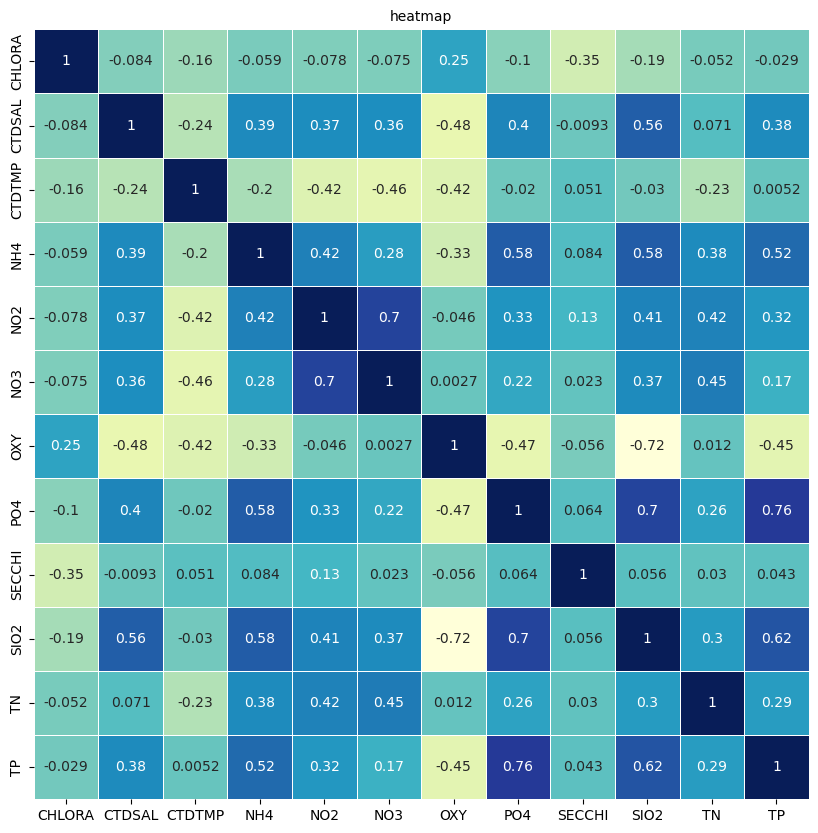

In [11]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(X_missing_reg.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})
# sns.heatmap(X_missing_mean.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})
# sns.heatmap(X_missing_0.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('heatmap',fontsize=10)
plt.show()